# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: Llama 3.1 8B
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading Llama 3.1 8B model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in IMDB Dataset

In [18]:
!pip install -q "datasets>=2.16.1"
!pip install torch
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 12.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━

In [3]:
from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42)

# Show the dataset
ds

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/importlib/__init__.py:126: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  return _bootstrap._gcd_import(name[level:], package, level)


{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 14579
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 4747
 })}

### Dataset Exploration

In [4]:
import pandas as pd

train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [5]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407' 'qq' 'pp' 'h']


In 4 number of formats/categories

In [6]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author' 'amt']


Dataset sample text length just skew towards 335 characters or less 

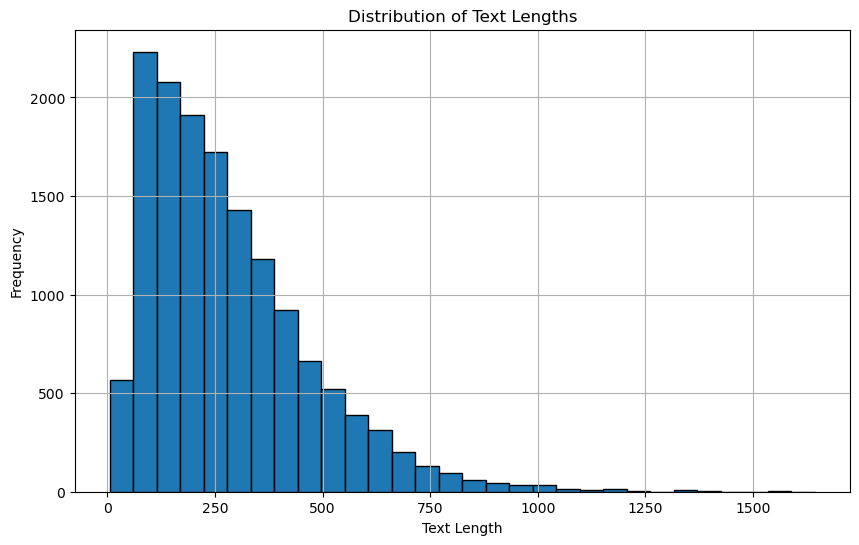

In [7]:
import matplotlib.pyplot as plt

train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Intial Llama 3.1 8B evaluation on the dataset
Going to load in the Llama model through AutoModelForSequenceClassification and set the label ids

In [8]:
import torch
print(torch.__version__)

2.4.1+cu121


In [9]:
from transformers import AutoModelForSequenceClassification

num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

model = AutoModelForSequenceClassification.from_pretrained(
    "meta-llama/Meta-Llama-3.1-8B",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407', 11: 'qq', 12: 'pp', 13: 'h'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10, 'qq': 11, 'pp': 12, 'h': 13}


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3.1-8B.
401 Client Error. (Request ID: Root=1-66e96cdd-0860cd1013ba23752b55fc52;98e25dcc-1093-4240-82a6-d98cbd3d55a6)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B/resolve/main/config.json.
Access to model meta-llama/Meta-Llama-3.1-8B is restricted. You must have access to it and be authenticated to access it. Please log in.